# Specialized neural networks 

In the previous lecture, we found that a pretty generic multilayer perceptron could predict discharge with reasonable accuracy. We could use a similar model to classify our images but it wouldn't really make sense given that a fully-connected multilayer perceptron would treat all pixels independently and have no conception of **spatial structure**. 

In this lecture, we will introduce a special type of neural network architecture called **convolutional networks**. The architecture makes convolutional networks fast to train, able to to identify spatial structure, and very good at image classification. These type of networks have rapidly advanced the field of computer vision and have the potential to dramatically expand the kinds of Earth Science questions we ask from satellite images.

## Example - how much water is in these satellite images?

We will return to our image classification task to demonstrate convolutional networks. In this demo, we have **100 tiles** of the ice sheet surface acquired by SkySat. These tiles have dimensions of **320 x 320 x 4** which represent the number of rows, columns, and bands (i.e. RGB-NIR) in the satellite image. Alongside these tiles, we have a table that contains the **fraction of water** in each tile (i.e. labels). 

```{important}
Our goal is to train a convolutional network to predict water fraction from information contained in the tiles (e.g. spectral reflectance, spatial structure). 
```

In [123]:
# Import packages
import matplotlib.pyplot as plt
import glob
import rasterio
import numpy as np
import pandas as pd

# Define labels
df = pd.read_csv('data/water-fraction.csv')

# Define tiles
tiles = sorted(glob.glob('data/tiles/*.tif'))
print(len(tiles))

100


In [124]:
print(df['fraction'])

0     0.000000
1     0.000000
2     0.000000
3     0.011221
4     0.000400
        ...   
95    0.059541
96    0.111094
97    0.142324
98    0.158281
99    0.157617
Name: fraction, Length: 100, dtype: float64


Let's also show some examples of the tiles.

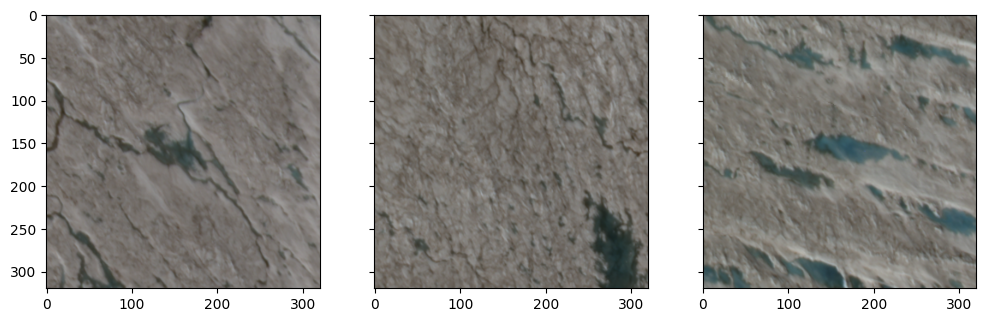

In [125]:
rgbs = []
for i in [6, 7, 8]:
    with rasterio.open(tiles[i]) as src:
        bands = [src.read(j) for j in range(1, 4)]
        rgbs.append(np.dstack(bands[::-1]))

# Plot as RGB images
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
for ax, rgb in zip(axes, rgbs):
    ax.imshow(rgb)
plt.show()

## Segmentation vs. classification

Given our previous experience with this task, our first intuition might be to classify every pixel in the tile as water or non-water, then sume the number of water pixels. This would be called **semantic segmentation** and it is a perfectly reasonable approach. However, since our goal is just to quantify how much water is in every tile, that might be overkill. 

Instead, we are just going to predict a single label (a continuous value between 0 and 1) for every tile. This kind of task is (perhaps confusingly) called **image classification** in computer science. What we're doing is therefore similar to other image recognition tasks where the model processes an image and assigns a single categorical label (e.g. dog, cat, car).

```{image} images/hierarchy.png
:width: 800px
:align: center
```

## Architecture

We will be using `TensorFlow` again to define our convolutional network. 

In [128]:
from tensorflow.keras import layers, models, optimizers, Input

# Define image size
img_size = src.width, src.height, src.count

# Define model
def build_cnn(input_shape=(img_size)):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(16, (5,5), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(16, (5,5), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(16, (5,5), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='mse',  
                  metrics=['mae'])
    return model

model = build_cnn()

## Local receptive fields

We'll notice that our convolutional network has some different **types of layers**. The first type is called a `Conv2D` (2D convolution layer) which we can think of as a **filtering operation**. The filter (also known as a **local receptive field**) in our model has a kernel size of **5 x 5 pixels**. We can slide this filter across our image, computing **dot products** to map values from the input layer onto the next layer. This process is called **convolution**. 

```{image} images/filter.png
:width: 700px
:align: center
```

In traditional image processing, we would manually define the **weights** of the filter. For example we could use a Gaussian filter to reduce noise or a Laplacian filter to enhance edges. 

Our `Conv2D` layer however initializes the 5 x 5 kernel weights **randomly**. During training, backpropagation updates these weights so that the filter outputs different spatial structures (e.g. water boundaries, textures, shapes). We have set our `Conv2D` layer to produce **16 different filters** (or feature maps). 

```{note}
Our `Conv2D` layer converts our 320 x 320 x 4 image into 316 x 316 x 16 feature maps because we can only move the local receptive field 316 nodes across (or 316 nodes down) before colliding with the right-hand side (or bottom) of the input image.
```

## Shared weights and biases

We might be thinking that the number of parameters of a convolutional network must be huge. For example, a 320 x 320 x 4 image would have 409,600 input nodes. If these were fully-connected to 32 nodes in a hidden layer (a relatively modest number), the number of parameters would be over 13 million. However, when we print our `model.summary()` we find that our `Conv2D` layer **only has 1,616 parameters**. How can this be?

Whereas layers in our multilayer perceptron were fully-connected, each feature map (16 of them) is produced using a kernel that uses the **same weights and bias across the entire image**. In other words, the first `Conv2D` layer detects exactly the same feature, just at different locations in the input image. This is advantageous because nodes in this layer that learn how to detect a particular feature in one part of the image will also be able to detect the same feature in other places in the image.

The number of parameters for a `Conv2D` layer is therefore a function of 1) the size of the kernel (each pixel in the kernel must have a weight), 2) the number of bands in the input image, and 3) the number of feature maps. For our first `Conv2D` layer, this would be: (5 x 5 x 4 + 1) x 16 = 1,616. For our second `Conv2D` layer, this would be: (5 x 5 x 16 + 1) x 16 = 1,616, noting that the previous convolutional layer **increased the number of bands to 16**.  

```{image} images/kernel-weights.png
:width: 500px
:align: center
```

Most of the parameters in our convolutional network are therefore the weights associate with our 5 x 5 kernels. Above is an example of what these kernels may look like. Whiter colors represent smaller weights and darker weights represent larger weights. The weights in each kernel are continuously updated during training so that they become more or less sensitive to spatial structure in our image (e.g. edges). 

By substantially reducing the number of parameters in our model, shared weights will allow us train our convolutional networks faster which, in turn, will allow us to experiment with developing deeper networks. Sharing weights therefore enables the development of complex models without the computational overhead. This alone is a major reason for why convolutional networks have made so many breakthroughs in machine learning. 

In [129]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 316, 316, 16)   │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 158, 158, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 154, 154, 16)   │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 77, 77, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 73, 73, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 36, 36, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,601 (60.94 KB)

 Trainable params: 15,601 (60.94 KB)

 Non-trainable params: 0 (0.00 B)

## Pooling

The second type of layer we use in convolutional networks is a **pooling layer**. These layers **downsample** the outputs produced by a convolutional layer so are usually used immediately the `Conv2D` layers. In our model, we defined `MaxPooling2D((2,2))` which simply outputs the maximum activation for each 2 x 2 input region in our image. There are other pooling techniques such as **L2 pooling** which compute the square root of the sum of the squares of the activations in the 2 x 2 region. 

```{image} images/pooling.png
:width: 700px
:align: center
```

Pooling using a 2 x 2 input region reduces the number of nodes in our network by half. Hence the output of the pooling layer has a dimension of 158 x 158 x 16. This is useful for increasing computational efficiency. It may also make the model more robust to slight variations in the position of features, thereby improving a property known as **translational invariance**. 

Towards the end of our network, we use another type of pooling layer called `GlobalAveragePooling2D`. This layer averages each feature map to a single nodes. In our case, 16 feature maps because 16 nodes. Again there are several reasons for this layer including computational efficiency, prevention of overfitting. It also ensures the network focuses on whether a feature exists, not *where* it is.

## Fully-connected neural network

The final couple of layers of our network are fully-connected, just like the multilayer perceptron we described in the previous lecture. We first have a `Dense` layer that connects all 16 nodes from the `GlobalAveragePooling2D` layer to every one of the 64 output nodes. We then have another `Dense` layer that connects all 64 of these nodes to a single node which is subsequently normalized using a `sigmoid` activation function to predict a value between 0 and 1. 

## Network training

Now we have some understanding of the convolutional network, let's train it.

```{note}
The training procedure is exactly the same as a multilayer perceptron (i.e. end-to-end with backprop + gradient descent).
```

First we will define some helper functions to read the GeoTiff tiles and convert them into a a tensorflow dataset. 

In [131]:
from sklearn.model_selection import train_test_split

# Function to load GeoTIFF with rasterio
def _load_geotiff(path):
    with rasterio.open(path) as src:
        img = src.read([1, 2, 3, 4])
        img = np.transpose(img, (1, 2, 0))
    return img.astype("float32")

# TensorFlow wrapper
def load_image(path, label):
    img = tf.numpy_function(
        func=lambda p: _load_geotiff(p.decode("utf-8")),
        inp=[path],
        Tout=tf.float32
    )
    img.set_shape((img_size))
    img = img / 255.0
    return img, tf.cast(label, tf.float32)

# Make TF dataset
def make_dataset(files, labels, batch_size=10, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

Now we will split into training, testing, and validation datasets. 

In [132]:
# Split
train_files, test_files, train_labels, test_labels = train_test_split(
    df["tile"], df["fraction"], test_size=0.2, random_state=42)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.25, random_state=42)

train_ds = make_dataset(train_files.values, train_labels.values)
val_ds   = make_dataset(val_files.values, val_labels.values, shuffle=False)
test_ds  = make_dataset(test_files.values, test_labels.values, shuffle=False)

It might be possible to train our model using all 100 image-label pairs but, in most cases, our training dataset will be too large to load into memory all at once. We therefore train the model in batches. We can inspect one batch like so:

In [133]:
for batch in train_ds.take(1):
    print(batch[0].shape) 
    print(batch[1].shape)

(10, 320, 320, 4)
(10,)


This tells us that each batch contains 10 tiles with 10 corresponding labels. 

## Fit and evaluate model

We fit the model to the training dataset, using the the validation dataset to monitor the model performance. 

In [119]:
# Fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=0
)

In [120]:
# Evaluate
model.evaluate(test_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Final test accuracy: {test_acc:.3f} or {(test_acc/df['fraction'].mean())*100:.1f}%")

Final test accuracy: 0.027 or 12.7%


In [121]:
# Predict all test images
predicted = []
actual = []
for i in range(len(test_files)):
    
    # Load the image
    src = rasterio.open(test_files.iloc[i])
    img = src.read([1, 2, 3, 4])
    img = img.astype(np.float32)
    img = img / 255.0
    img = np.moveaxis(img, 0, -1)
    
    # Add batch dimension
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img, verbose=0)
       
    # Append
    predicted.append(prediction[0][0])
    actual.append(test_labels.iloc[i])

results = pd.DataFrame(list(zip(actual, predicted)), columns=['actual', 'predicted'])
results.head()

,actual,predicted
0,0.358291,0.284476
1,0.052187,0.025802
2,0.062305,0.062378
3,0.655342,0.595010
4,0.945088,0.937685


Text(0, 0.5, 'Predicted water fraction')

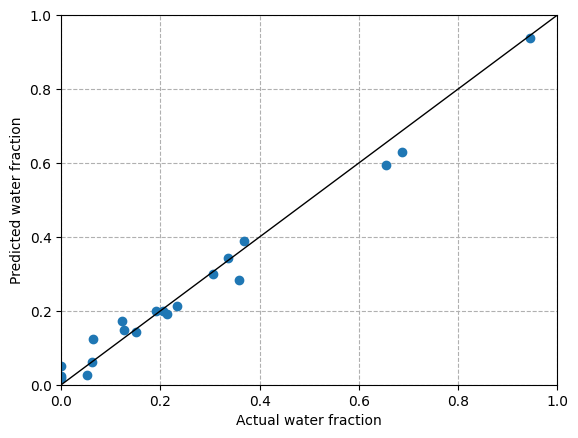

In [122]:
plt.scatter(actual, predicted, zorder=2)
plt.plot([0,1],[0,1], color='k', lw=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(ls='dashed', zorder=1)
plt.xlabel('Actual water fraction')
plt.ylabel('Predicted water fraction')

## Semantic segmentation

We have trained a convolutional network to predict water fraction from a single 320 x 320 tile which is fine for answering our research question. But some tasks may require us to classify individual pixels in the input image (i.e. **semantic segmentation**). To do this, we would have to enhance the resolution of the feature maps using an `UpSampling2D` layer. We would also have to preserve the original dimensions of our input layer by **padding** the edges of the image so that our upsampling is able to restore our image to 320 x 320 pixels using upsampling. 

```{note}
The "U-shaped" downsampling followed by upsampling is why these type of convolutional networks are called **U-Nets**.
```

Below is the architecture of a simple U-Net model defined using `TensorFlow`.

In [135]:
def unet_model(input_shape=(img_size)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D(2)(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D(2)(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model.compile(optimizer='adam',
              loss='mse',  
              metrics=['mae'])
    
    return model

## ImageNet 

ImageNet is a image dataset containing >14,000,000 images, all of which are described by single (e.g. chair, cat) or multiple (e.g. African elephant, soccer ball) words. Images were crawled from the internet and classified by workers from Amazon's Mechanical Turk service. 

```{image} images/imagenet.png
:width: 800px
:align: center
```

Between 2010-2017, researchers competed in **ImageNet Large Scale Visual Recognition Challenge** (ILSVRC) to see who could design the most accurate model for classifying images in ImageNet. In 2012, AlexNet, a **deep convolutional network**, won the competition by a large margin (top-5 error of ~15% vs ~26%). This breakthrough is considered to have launched the **deep learning revolution** in computer vision.
Convolutional networks dominated image recognition tasks between 2012-2020. 

## Other types of specialized neural network

The examples that we have studied provide a foundation for understanding other types of neural network (there are many). One limitation of traditional neural networks is that they are very **static**. They require labelled training data with a fixed shape and the final model has **no memory** of the weights and biases from earlier in the training period. 

**Recurrent neural networks** process sequences of data one step at a time, maintaining a hidden state that carries information from previous steps. At each new input, the network updates this hidden state and produces an output, which makes RNNs well-suited for tasks where order and context over time matter, like language or time-series prediction.

```{image} images/rnn.png
:width: 700px
:align: center
```

The challenge with RNNs is that they are difficult to train because gradients tend to either **vanish** or **explode**, especially for longer sequences of inputs. This problem was overcome by the development of **long short-term memory (LSTMs)networks** and **gated recurrent networks (GRUs)**. 

Given enough data and compute, **transformers** can match or outperform convolutional networks on image classification tasks. Since 2021, **Vision Transformers (ViT)** treat the image as a sequence of tokens (or "patches") and use **global self-attention** to capture spatial structure across the entire image.

# Practical methodology

Successful application of deep learning requires more than just a good knowledge of what algorithms exist and the principles that explain how they work. A good deep learning **practitioner** is someone that can choose the right algorithm for a particular application and is able to improve models by intelligently responding to feedback from experiments (as opposed to blindy guessing). We will conclude this unit by discussing some strategies that should guide practical design of deep learning workflows.

```{image} images/machine-learning-xkcd.png
:width: 500px
:align: center
```
[https://xkcd.com/1838/](https://xkcd.com/1838/)

## Performance metrics

Defining the desired error rate and error metric is a necessary first step in any project because it can be used to guide future actions.

### Error rate

For most applications, it is **impossible to achieve zero error** because environmental datasets contain **noise**. 

* We have a finite amount of training data that does not fully represent all possible conditions in the system (e.g. 100-year flood)

* Our input features may not contain complete information about the output variable (e.g. seasonal vegetation changes)

* There is random variation in our input and output variabes (e.g. measurement error)

We should therefore **define an acceptable error rate** in the early stage a project. In academic settings, this may be based on previous studies that represent the "state-of-the-art" (SoTA). In commercial settings, this may be defined as the error rate required for an application to be safe, cost-effective, or appealing to consumers.  

### Error metrics

Several different metrics cna be used to measure the performance of an application. These performance metrics are usually different from the loss function used to train the model (i.e. usually MSE or MAE in regression tasks). 

Many applications require more insightful metrics. For our river discharge prediction, we used the Nash-Sutcliffe efficiency (NSE) coefficient to evaluate the predictive skill of our model for the whole 365-day period. The difference between prediction and observations is therefore treated the same every day. 

But what if we our goal was to predict discharge during winter or during flood events? We might want to use a different performance metric such as a flood event efficiency coefficient that evaluates the difference between predictions and observations **only during flood events** above some threshold discharge. 

Likewise, in our image classification task, we were more concerned about **overestimating** surface water coverage than underestimating it. We therefore produced a confusion matrix to investigate the **precision** of our model (i.e. fraction of predicted water pixels that were correct). We were less concerned about **recall** (i.e. fraction of observed water pixels that were correctly predicted). 

In contrast, when it is costly to miss true values (e.g. natural hazards), we might place more emphasis on recall. Choosing a good error metric is therefore important. Without one, it can be challenging to determine whether changes to a machine learning system is making progress or not. 

## Baseline model

The next step in any practical application is to **establish a reasonable end-to-end system as soon as possible**. The baseline model depends on the structure of the data. If the problem involves structured data (i.e. tabular), the baseline might be a simple statistcial model like logistic regression with a few linear weights. If the problem falls into the "AI-complete" category (i.e. computer vision, natural language processing), the baseline probably has to be an appropriate deep learning model. 

Start with commonly used activation functions (e.g. ReLUs) and optimization algorithms (e.g. SGD + momentum or Adam). If your task is similar to another task that has been studied extensively, you could clone that model. You could even use a **pre-trained** model that has been developed for a similar task. For example, many studies use models that were trained on **ImageNet** (e.g. ResNet) to solve other computer vision tasks. 

## More data?

After designing an end-to-end system **with acceptable performance**, we may be tempted to start trying out different algorithms and tinkering with the parameters. But it is usually often much better to **gather more data** than improve the learning algorithm. Major breakthroughs in deep learning have actually been realized by development of large labelled datasets (e.g. ImageNet). 

```{image} images/more-data.png
:width: 600px
:align: center
```

We can determine whether we need more data by plotting the relationships between training dataset size and testing error (i.e. learning curve). By extrapolating the curves, we can predict how much additional data would be required to achieve a certain level of performance. 

If gathering more data is not feasible (e.g. time-consuming, costly), we could pursue **data augmentation**. For example, flipping, rotating, or shifting image tiles used by our image classifiers. Or training our discharge prediction model on data from adjacent watersheds that exhibit similar behaviour but which have longer records. 

## Selecting hyperparameters

Almost all deep learning approaches involve several hyperparameters that control aspects of the algorithm's behaviour. Some of these hyperparameters affect the time and memory cost of running the algorithm. Others affect the quality of the model recovered by the training process. Currently there is no general theory that we can use for hyperparameter tuning (i.e. if X do Y). Choosing hyperparameters therefore requires developing good intuition about machine learning models and how to improve their ability to generalize. 

If we have a good understanding of the fundamental relationships between hyperparameters, training error, testing error, and computational resources, we may be able to **tune hyperparameters manually**. The generalization error usually follows a U-shaped curve when plotted as a function of the one of the hyperparameters. At one extreme, the value of the hyperparameter corresponds to a model with **low complexity** which **underfits** the training data (i.e. training error is high). At the other end, the value of the hyperparameter corresponds to a model with **high complexity** which **overfits** the training data (i.e. training error is low). 

```{image} images/capacity-vs-error.png
:width: 600px
:align: center
```

**Learning rate** is probably the most important hyperparameter to tune. Too high and gradient descent can inadvertently increase, rather than decrease, the training error. Too small and the training becomes very slow and may become permanently stuck.

Tuning other hyperparameters requires **monitoring both the training and the testing error** to diagnose whether the model is overfitting or underfitting. 

Neural networks typically perform best when the training error is low. So if your training error is high, then we have no choice but to **increase the complexity of the model**, either by adding more layers to the network or adding more nodes. Major breakthroughs occurred in deep learning when researchers developed networks with more layers that enabled more expressive models. 

Once we have sufficiently reduced the training error, we can work on improving the testing error by tuning hyperparameters. We can avoid overfitting by reducing the complexity of the model using **regularization** (e.g. dropout or weight decay). 

```{tip}
The best performing model is usually a large model that has been regularized well.
```

One way to guarantee success is to continually increase model complexity until the task is solved. But in reality, we are limited by computational resources and time. If our model is too complex, then training will take too long and we won't have time to search for optimal hyperparameters. The optimal model complexity therefore depends on computational resources and time which will vary widely depending on the setting. 

## Automated hyperparameter optimization algorithms

While manual hyperparameter tuning can work well, automated hyperparameter tuning is generally considered the conventional approach. The most simple approach is to perform a **grid search** where the user selects a finite set of values to explore. The grid search algorithm then trains a model for every combination of hyperparameter values. The experiment that yields the lowest validation error is then selected. Grid search usually performs best when applied repeatedly. If the lowest error was identified at the edge of the value set, then the value set should be updated. 

```{image} images/gridsearch.png
:width: 600px
:align: center
```

```{note}
The obvious problem with grid search is that the computational cost grows exponentially with the number of hyperparameters.
```
An alternative approach is **random search** which often converges to good hyperparameter values much faster than grid search. One advantage of random search is that we could run it for any time period we like. Even if it finishes, we could restart with the hope of finding better hyperparameter values. 

## Further reading

Bishop, C. M. (2006). [Pattern recognition and machine learning](https://link.springer.com/9780387310732)

Goodfellow, I., Bengio, Y., & Courville, A. (2017) [Deep learning](https://www.deeplearningbook.org/)

Karn, U. (2016). [An Intuitive Explanation of Convolutional Neural Networks](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)

Nielsen, M. A. (2015). [Neural networks and deep learning](http://neuralnetworksanddeeplearning.com/index.html)

Rohrer, B. (2019). [How convolutional neural networks work, in depth](https://www.youtube.com/watch?v=JB8T_zN7ZC0)